In [2]:
!pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 5.1 MB/s eta 0:00:00


In [3]:
# ==============================================================
# CARD few-shot eval with your MEGARes-trained MetaOptNet encoder- DRUG
# Toggle LABEL_TARGET in { "mechanism", "amr_gene_family", "drug_class" }
# ==============================================================

import os, re, json, math, random, numpy as np, pandas as pd
from pathlib import Path

# ---------------- user knobs ----------------
LABEL_TARGET = "drug_class"     # ← change to "drug_class" to run Drug
K_VALUES     = [1,3,5]
N, Q         = 5, 15           # 5-way, 15 queries per class
EPISODES     = 600
MAX_LEN      = 512
KMER_K       = 5

# input files
ARO_INDEX_PATH       = "aro_index.tsv"
ARO_CATEGORIES_PATH  = "aro_categories.tsv"   # optional
FASTA_PATH           = "nucleotide_fasta_protein_homolog_model.fasta"

# pretrained assets from MEGARes run
CKPT_PATH = "best_metaoptnet_cnn.pt"
STOI_PATH = "stoi.json"
NUM_MEAN  = "num_mean.npy"
NUM_STD   = "num_std.npy"

# ---------------- 0) helpers ----------------
def normalize_multi(x):
    parts = [p.strip() for p in str(x).replace("|",";").split(";") if p and p.strip()!="NA"]
    return "|".join(sorted(set(parts))) if parts else "NA"

# For drug_class you often get multi-values like: "cephalosporin|penicillin beta-lactam|carbapenem"
# Choose a single canonical label for few-shot:
#   strategy = "first"  -> take the first token
#   strategy = "collapse_beta" -> collapse ceph/peni/mono/carb to "beta-lactam"
DRUG_STRATEGY = "first"   # change to "collapse_beta" if you want coarser labels

def pick_drug_single(drug_str, strategy="first"):
    if drug_str is None or drug_str == "NA":
        return None
    toks = [t.strip() for t in drug_str.split("|") if t.strip()]
    if not toks: return None
    if strategy == "first":
        return toks[0]
    if strategy == "collapse_beta":
        beta = {"cephalosporin","penicillin beta-lactam","monobactam","carbapenem"}
        # if any is a beta-lactam subclass -> "beta-lactam"
        if any(t in beta for t in toks): return "beta-lactam"
        return toks[0]
    return toks[0]

# ---------------- 1) Build ARO -> labels table ----------------
idx = pd.read_csv(ARO_INDEX_PATH, sep="\t", dtype=str, engine="python")
idx.columns = [c.strip().lower().replace(" ", "_") for c in idx.columns]

def pick(cols, *keys):
    for c in cols:
        if all(k in c for k in keys):
            return c
    return None

aro_col  = pick(idx.columns, "aro", "accession")
name_col = pick(idx.columns, "aro", "name") or pick(idx.columns, "card", "short", "name")
fam_col  = pick(idx.columns, "amr", "gene", "family")
drug_col = pick(idx.columns, "drug", "class")
mech_col = pick(idx.columns, "resistance", "mechanism")

need = [aro_col, name_col, fam_col, drug_col, mech_col]
assert all(n is not None for n in need), f"Missing columns. Got: {dict(zip(['aro','name','fam','drug','mech'], need))}"

df = idx[[aro_col, name_col, fam_col, drug_col, mech_col]].copy()
df.columns = ["aro_accession","aro_name","amr_gene_family","drug_class","mechanism"]

for c in ["amr_gene_family","drug_class","mechanism","aro_name"]:
    df[c] = df[c].fillna("NA").astype(str).str.strip()

df["amr_gene_family"] = df["amr_gene_family"].map(normalize_multi)
df["drug_class"]      = df["drug_class"].map(normalize_multi)
df["mechanism"]       = df["mechanism"].map(normalize_multi)

agg = (
    df.groupby(["aro_accession"], as_index=False)
      .agg({
          "aro_name":          lambda s: sorted(set(s.dropna()))[0] if len(set(s.dropna())) else "NA",
          "amr_gene_family":   lambda s: normalize_multi("|".join(s.dropna())),
          "drug_class":        lambda s: normalize_multi("|".join(s.dropna())),
          "mechanism":         lambda s: normalize_multi("|".join(s.dropna())),
      })
)

try:
    cat = pd.read_csv(ARO_CATEGORIES_PATH, sep="\t", dtype=str, engine="python")
    cat.columns = [c.strip().lower().replace(" ", "_") for c in cat.columns]
    if {"aro_category","aro_accession","aro_name"}.issubset(set(cat.columns)):
        keep = cat[cat["aro_category"].isin(["AMR Gene Family","Drug Class","Resistance Mechanism"])].copy()
        ren = {"AMR Gene Family":"amr_gene_family", "Drug Class":"drug_class", "Resistance Mechanism":"mechanism"}
        keep["key"] = keep["aro_category"].map(ren)
        wide = (keep.pivot_table(index="aro_accession", columns="key", values="aro_name",
                                 aggfunc=lambda x: "|".join(sorted(set([str(v).strip() for v in x if str(v).strip()]))))
                .reset_index())
        agg = agg.merge(wide, on="aro_accession", how="left", suffixes=("","_cat"))
        for col in ["amr_gene_family","drug_class","mechanism"]:
            fill = np.where((agg[col].isna()) | (agg[col]=="NA"), agg[f"{col}_cat"].fillna("NA"), agg[col])
            agg[col] = fill
        agg = agg.drop(columns=[c for c in agg.columns if c.endswith("_cat")])
except FileNotFoundError:
    pass

agg.to_csv("label_map.csv", index=False)
print(f"[OK] Wrote label_map.csv  rows={len(agg)}")

# ---------------- 2) Build seq_manifest.csv ----------------
from Bio import SeqIO
ARO_RE = re.compile(r"(ARO:\d{7})")

rows = []
for rec in SeqIO.parse(FASTA_PATH, "fasta"):
    desc = rec.description
    m = ARO_RE.search(desc)
    aro = m.group(1) if m else None
    rows.append({
        "seq_id": desc.split()[0],
        "aro_accession": aro,
        "sequence": str(rec.seq).upper().replace("U","T"),
    })

man = pd.DataFrame(rows)
lm  = pd.read_csv("label_map.csv", dtype=str)

merged = man.merge(lm, on="aro_accession", how="inner")
merged["sequence"] = merged["sequence"].str.replace(r"[^ACGT]", "", regex=True)
merged = merged[merged["sequence"].str.len() >= 50].copy()
merged["seq_len"] = merged["sequence"].str.len()
merged["gc_content"] = merged["sequence"].map(lambda s: (s.count("G")+s.count("C"))/len(s))

# make single-valued labels for the chosen target
if LABEL_TARGET == "drug_class":
    merged["drug_single"] = merged["drug_class"].map(lambda s: pick_drug_single(s, strategy=DRUG_STRATEGY))
    merged = merged[merged["drug_single"].notna()].copy()
    label_col = "drug_single"
else:
    # mechanism & amr_gene_family are usually single already; if multi, take the first tag
    def first_token(x):
        toks = [t.strip() for t in str(x).split("|") if t.strip()]
        return toks[0] if toks else None
    merged[LABEL_TARGET] = merged[LABEL_TARGET].map(first_token)
    merged = merged[merged[LABEL_TARGET].notna()].copy()
    label_col = LABEL_TARGET

merged.to_csv("seq_manifest.csv", index=False)
print(f"[OK] Wrote seq_manifest.csv  rows={len(merged)}  label={label_col}")

# ---------------- 3) Make few-shot splits ----------------
def make_splits(df, label, K, out_root, episodes=EPISODES, N=N, Q=Q, seed=42):
    np.random.seed(seed)
    counts = df[label].value_counts()
    labels = counts[counts >= (K + Q)].index.tolist()
    print(f"  K={K}: usable classes={len(labels)}")
    outK = out_root / f"K{K}"
    outK.mkdir(parents=True, exist_ok=True)
    for epi in range(episodes):
        if len(labels) < N: break
        picked = np.random.choice(labels, size=N, replace=False)
        S, Qr = [], []
        for lab in picked:
            cand = df[df[label]==lab]
            idx = np.random.choice(cand.index, size=K+Q, replace=False)
            S.append(cand.loc[idx[:K], ["seq_id", label]])
            Qr.append(cand.loc[idx[K:], ["seq_id", label]])
        epdir = outK / f"episode_{epi:04d}"
        epdir.mkdir(exist_ok=True, parents=True)
        pd.concat(S).to_csv(epdir/"support.csv", index=False)
        pd.concat(Qr).to_csv(epdir/"query.csv",   index=False)

df = pd.read_csv("seq_manifest.csv", dtype={"seq_len":float,"gc_content":float})
SPLITS_ROOT = f"splits_{label_col}"
Path(SPLITS_ROOT).mkdir(exist_ok=True)
print(f"[Splits] target={label_col}  root={SPLITS_ROOT}")
for K in K_VALUES:
    make_splits(df, label_col, K, Path(SPLITS_ROOT))

# ---------------- 4) Evaluate with your MEGARes encoder ----------------
import torch, torch.nn as nn, torch.nn.functional as F

with open(STOI_PATH) as f:
    stoi = json.load(f)
PAD, UNK = "<PAD>", "<UNK>"
pad_id = stoi.get(PAD, 0); unk_id = stoi.get(UNK, 1)
num_mean = np.load(NUM_MEAN); num_std = np.load(NUM_STD)

def kmers(seq, k=KMER_K):
    L = len(seq);
    return [seq[i:i+k] for i in range(L-k+1)] if L>=k else []

def encode_seq_ids(seq):
    toks = kmers(seq, KMER_K)
    if not toks: return [unk_id]
    return [stoi.get(t, unk_id) for t in toks]

def pad_ids(ids, max_len=MAX_LEN):
    out = np.full((max_len,), pad_id, dtype=np.int64)
    s = ids[:max_len]
    out[:len(s)] = s
    return out

class CNNSeqEncoder(nn.Module):
    def __init__(self, vocab_size, pad_idx, max_len,
                 embed_dim=256, token_dim=128,
                 conv_channels=96, kernel_sizes=(3,5,7),
                 use_cosine=True, num_features=2):
        super().__init__()
        self.use_cosine = use_cosine
        self.emb = nn.Embedding(vocab_size, token_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(0.20)
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(token_dim, conv_channels, k, padding=k//2),
                nn.ReLU(),
                nn.Dropout1d(0.10)
            ) for k in kernel_sizes
        ])
        self.num_proj = nn.Sequential(nn.Linear(num_features, 32), nn.ReLU(), nn.BatchNorm1d(32))
        fused_in = conv_channels*len(kernel_sizes)*2 + 32
        self.proj = nn.Sequential(nn.Linear(fused_in, 512), nn.ReLU(), nn.BatchNorm1d(512), nn.Dropout(0.50),
                                  nn.Linear(512, 256))
        # keep to match checkpoint keys
        self.log_temp = nn.Parameter(torch.zeros(1))
    def forward(self, tokens, nums):
        x = self.emb(tokens)
        x = self.emb_dropout(x).transpose(1,2)
        pooled = []
        for block in self.convs:
            h = block(x)
            pooled += [F.adaptive_max_pool1d(h,1).squeeze(-1),
                       F.adaptive_avg_pool1d(h,1).squeeze(-1)]
        h_text = torch.cat(pooled, dim=1)
        h_num  = self.num_proj(nums)
        z = self.proj(torch.cat([h_text, h_num], dim=1))
        return F.normalize(z, p=2, dim=1) if self.use_cosine else z

def ridge_logits(s_z, s_y, q_z, l2=1e-3):
    C = int(s_y.max().item())+1
    Y = F.one_hot(s_y, num_classes=C).float()
    A = s_z.t() @ s_z + l2*torch.eye(s_z.shape[1], device=s_z.device)
    B = s_z.t() @ Y
    W = torch.linalg.solve(A, B)
    return q_z @ W

manifest = pd.read_csv("seq_manifest.csv", dtype={"seq_len":float,"gc_content":float})
seq_by_id = manifest.set_index("seq_id").to_dict(orient="index")

def load_episode(ep_dir, label=label_col, device="cpu"):
    S = pd.read_csv(ep_dir/"support.csv")
    Q = pd.read_csv(ep_dir/"query.csv")
    labs = sorted(S[label].unique())
    lab2id = {l:i for i,l in enumerate(labs)}
    def pack(df):
        toks, nums, ys = [], [], []
        for _, r in df.iterrows():
            rec = seq_by_id[r["seq_id"]]
            ids = pad_ids(encode_seq_ids(rec["sequence"]), MAX_LEN)
            toks.append(ids)
            nums.append([rec["gc_content"], rec["seq_len"]])
            ys.append(lab2id[r[label]])
        toks = torch.tensor(np.stack(toks)).long().to(device)
        nums = torch.tensor((np.stack(nums)-num_mean)/(num_std+1e-6)).float().to(device)
        ys   = torch.tensor(ys).long().to(device)
        return toks, nums, ys
    return *pack(S), *pack(Q), labs

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNSeqEncoder(vocab_size=len(stoi), pad_idx=pad_id, max_len=MAX_LEN).to(device)
ckpt = torch.load(CKPT_PATH, map_location=device)
res = model.load_state_dict(ckpt, strict=True)
print("[OK] Loaded encoder. Missing:", res.missing_keys, "Unexpected:", res.unexpected_keys)
model.eval()

for K in K_VALUES:
    ep_root = Path(SPLITS_ROOT)/f"K{K}"
    ep_dirs = sorted([p for p in ep_root.iterdir() if p.is_dir()])[:EPISODES]
    accs = []
    for ep in ep_dirs:
        s_tok, s_num, s_y, q_tok, q_num, q_y, _ = load_episode(ep, label=label_col, device=device)
        with torch.no_grad():
            s_z = model(s_tok, s_num)
            q_z = model(q_tok, q_num)
            logits = ridge_logits(s_z, s_y, q_z, l2=1e-3)
            pred = logits.argmax(dim=1)
            accs.append((pred==q_y).float().mean().item())
    accs = np.array(accs, float)
    print(f"[CARD @ {label_col}] K={K}: acc={accs.mean():.3f} ± {accs.std():.3f} (n={len(accs)})")



[OK] Wrote label_map.csv  rows=6440
[OK] Wrote seq_manifest.csv  rows=6052  label=drug_single
[Splits] target=drug_single  root=splits_drug_single
  K=1: usable classes=15
  K=3: usable classes=15
  K=5: usable classes=15
[OK] Loaded encoder. Missing: [] Unexpected: []
[CARD @ drug_single] K=1: acc=0.379 ± 0.096 (n=600)
[CARD @ drug_single] K=3: acc=0.470 ± 0.094 (n=600)
[CARD @ drug_single] K=5: acc=0.511 ± 0.089 (n=600)


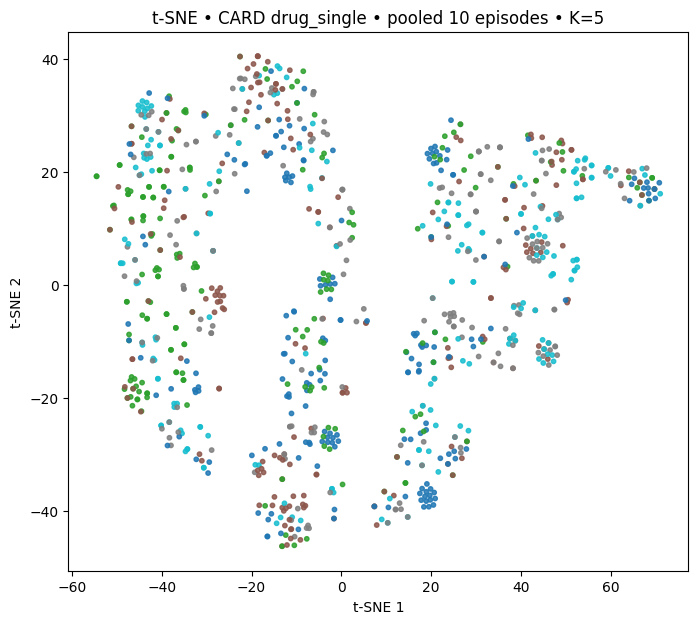

In [4]:
# ---------------- 5) (optional) pooled t-SNE over 10 episodes ----------------
DO_TSNE = True
if DO_TSNE:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    K_PICK = max(K_VALUES)
    root = Path(SPLITS_ROOT)/f"K{K_PICK}"
    eps = sorted([p for p in root.iterdir() if p.is_dir()])[:10]
    Zs, Ys = [], []
    for ep in eps:
        s_tok, s_num, s_y, q_tok, q_num, q_y, labs = load_episode(ep, label=label_col, device=device)
        with torch.no_grad():
            Zs.append(model(s_tok, s_num).cpu().numpy())
            Zs.append(model(q_tok, q_num).cpu().numpy())
            Ys.append(s_y.cpu().numpy()); Ys.append(q_y.cpu().numpy())
    X = np.vstack(Zs); y = np.concatenate(Ys)
    perpl = min(30, max(5, len(X)//4 - 1))
    X2 = TSNE(n_components=2, perplexity=perpl, random_state=42).fit_transform(X)
    plt.figure(figsize=(8,7))
    plt.scatter(X2[:,0], X2[:,1], c=y, s=10, cmap="tab10", alpha=0.85)
    plt.title(f"t-SNE • CARD {label_col} • pooled 10 episodes • K={K_PICK}")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2"); plt.show()
